In [2]:
from config import EPISODE_LEN
from env_utils import get_4wt_symmetric_env
from stable_baselines3 import PPO
import numpy as np
import tqdm

evaluations = 100

2024-10-17 16:18:41.249892: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 16:18:41.278625: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 16:18:41.553841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 16:18:43.257086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Evaluate PPO models

In [1]:
def evaluate_model(model, env, evaluations):
    total_rewards = np.zeros((evaluations, EPISODE_LEN))
    total_powers = np.zeros((evaluations, EPISODE_LEN))
    obs, info = env.reset()
    print(len(obs))
    print(info)
    for i in tqdm.tqdm(range(evaluations)):
        for j in range(EPISODE_LEN):
            action, _states = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            total_rewards[i, j] = reward
            total_powers[i, j] = info["power_output"]
            if terminated or truncated:
                break
        env.reset()
    return total_rewards, total_powers

models = [
    #("PPO unpriv", PPO.load("ppo_4wt_symmetric_unprivileged_cw_t1000000.0"), None),
    #("PPO priv 75", PPO.load("ppo_4wt_symmetric_privileged_md75_cw_t1000000.0_t1000000.0"), 75)
    ("PPO unpriv alignedreset", PPO.load("data/models/ppo_4wt_symmetric_unprivileged_cw_t1000000.0"), None),
    #?("PPO priv 75 alignedreset", PPO.load("data/models/ppo_4wt_symmetric_privileged_md75_cw_t1000000.0"), 75)
]
for model_name, model, mast_distancing in models:
    privileged = mast_distancing is not None
    env = get_4wt_symmetric_env(
        episode_length=EPISODE_LEN, 
        privileged=privileged, 
        mast_distancing=mast_distancing,
        changing_wind=True,
    )
    rewards, powers = evaluate_model(model, env, evaluations)
    np.save(f"data/{model_name}_rewards.npy", rewards)
    np.save(f"data/{model_name}_powers.npy", powers)

NameError: name 'PPO' is not defined

: 

# Evalute SR proportional controller

In [12]:
from serial_refine_agent import SR_ProportionalController
from env_utils import get_4wt_symmetric_env

# Load agent and environment
agent = SR_ProportionalController()
env = get_4wt_symmetric_env(episode_length=EPISODE_LEN, privileged=False, changing_wind=True, action_representation="yaw")

# Evaluate agent
obs, info = env.reset()
total_rewards = np.zeros((evaluations, EPISODE_LEN))
total_powers = np.zeros((evaluations, EPISODE_LEN))
for i in tqdm.tqdm(range(evaluations)):
    for j in range(EPISODE_LEN):
        wind_direction = env.wind_process.wind_direction
        current_yaws = env.yaws_from_wind

        action = agent.predict(wind_direction, current_yaws)
        obs, reward, terminated, truncated, info = env.step(action)

        total_rewards[i, j] = reward
        total_powers[i, j] = info["power_output"]

        if terminated or truncated:
            break
    env.reset()

np.save("data/SR_proportional_rewards.npy", total_rewards)
np.save("data/SR_proportional_powers.npy", total_powers)

# Evaluate agent in noisy environment
obs, info = env.reset()
total_rewards = np.zeros((evaluations, EPISODE_LEN))
total_powers = np.zeros((evaluations, EPISODE_LEN))
for i in tqdm.tqdm(range(evaluations)):
    for j in range(EPISODE_LEN):
        wind_direction = env.wind_process.wind_direction
        current_yaws = env.yaws_from_wind

        # Add noise to wind direction
        wind_direction = wind_direction + np.random.normal(0, 5)

        action = agent.predict(wind_direction, current_yaws)
        obs, reward, terminated, truncated, info = env.step(action)

        total_rewards[i, j] = reward
        total_powers[i, j] = info["power_output"]

        if terminated or truncated:
            break
    env.reset()

np.save("data/SR_proportional_noisy_rewards.npy", total_rewards)
np.save("data/SR_proportional_noisy_powers.npy", total_powers)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:43<00:00,  3.44s/it]


# Plot comparisons

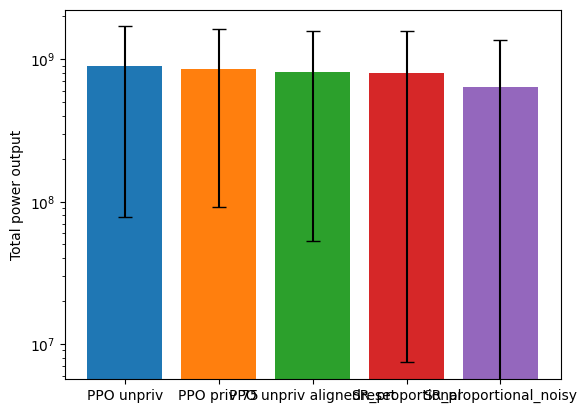

In [3]:
import matplotlib.pyplot as plt

models = ["PPO unpriv", "PPO priv 75", "PPO unpriv alignedreset", "SR_proportional", "SR_proportional_noisy"]

# Plot power for each model as barplot
fig, ax = plt.subplots()
for model in models:
    powers = np.load(f"data/{model}_powers.npy")
    ep_powers = powers.sum(axis=1)
    ax.bar(model, ep_powers.mean(), yerr=ep_powers.std(), capsize=5)
plt.ylabel("Total power output")
# Set the y axis to be between 1e10 and 1e8
plt.yscale("log")
plt.show()